In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import defaultdict
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset

In [ ]:
df_price = pd.read_csv("/content/drive/My Drive/Colab Notebooks/bert/AAPL_price.csv", sep=',', decimal=',',  parse_dates=['time'])
df_price['time'] = df_price['time'].dt.date
df_price = df_price.loc[:, ['time', 'median']]
df_price['median'] = df_price['median'].astype(float)
df_price['median_5_days'] = (df_price['median'].shift(1,fill_value=0) + 
                              df_price['median'].shift(2,fill_value=0) + 
                              df_price['median'].shift(3,fill_value=0) +
                              df_price['median'].shift(4,fill_value=0) +
                              df_price['median'].shift(5,fill_value=0)) / 5

df_price.loc[0:4, 'median_5_days'] = None
df_price['diff_medians'] = df_price['median'] - df_price['median_5_days']
df_price['diff_medians%'] = (df_price['diff_medians'] / df_price['median_5_days']) * 100
df_price.dropna(inplace=True)
df_price

,time,median,median_5_days,diff_medians,diff_medians%
5,2021-04-09,132.070007,126.463318,5.606689,4.433451
6,2021-04-12,131.309998,128.277319,3.032678,2.364158
7,2021-04-13,134.119995,129.408319,4.711676,3.640938
8,2021-04-14,132.899994,130.948318,1.951675,1.490417
9,2021-04-15,134.499893,132.084018,2.415875,1.829044
...,...,...,...,...,...
263,2022-04-18,164.820007,168.429858,-3.609851,-2.143237
264,2022-04-19,166.500000,167.245859,-0.745859,-0.445965
265,2022-04-20,167.229996,167.249860,-0.019864,-0.011877
266,2022-04-21,168.970001,167.123859,1.846143,1.104655


In [ ]:
df_price[df_price['diff_medians%'] == df_price['diff_medians%'].max()]

,time,median,median_5_days,diff_medians,diff_medians%
210,2022-01-31,173.029999,161.57464,11.455359,7.089825


In [ ]:
df_price[df_price['diff_medians%'] == df_price['diff_medians%'].min()]

,time,median,median_5_days,diff_medians,diff_medians%
205,2022-01-24,158.350006,168.278,-9.927994,-5.899757


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Difference of the median %')

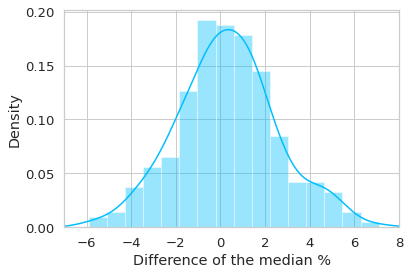

In [ ]:
sns.distplot(df_price['diff_medians%'])
plt.xlim([-7, 8]);
plt.xlabel('Difference of the median %')

In [ ]:
percentiles_25 = df_price['diff_medians%'].quantile([0.25]).values[0]
percentiles_25

-1.0432840098959182

In [ ]:
percentiles_75 = df_price['diff_medians%'].quantile([.75]).values[0]
percentiles_75

1.632770822006605

In [ ]:
conditions = [
    (df_price['diff_medians%'] >= percentiles_75),
    (df_price['diff_medians%'] < percentiles_75) & (df_price['diff_medians%'] > percentiles_25),
    (df_price['diff_medians%'] <= percentiles_25)]

# create a list of the values we want to assign for each condition
values = [1, 0, 2]

# create a new column and use np.select to assign values to it using our lists as arguments
df_price['label'] =  np.select(conditions, values)
df_price

,time,median,median_5_days,diff_medians,diff_medians%,label
5,2021-04-09,132.070007,126.463318,5.606689,4.433451,1
6,2021-04-12,131.309998,128.277319,3.032678,2.364158,1
7,2021-04-13,134.119995,129.408319,4.711676,3.640938,1
8,2021-04-14,132.899994,130.948318,1.951675,1.490417,0
9,2021-04-15,134.499893,132.084018,2.415875,1.829044,1
...,...,...,...,...,...,...
263,2022-04-18,164.820007,168.429858,-3.609851,-2.143237,2
264,2022-04-19,166.500000,167.245859,-0.745859,-0.445965,0
265,2022-04-20,167.229996,167.249860,-0.019864,-0.011877,0
266,2022-04-21,168.970001,167.123859,1.846143,1.104655,0


In [ ]:
df_news = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bert/AAPL_news.csv', sep=',', decimal=',',  index_col=0)
df_news

,ticker,date,source,title,description,url,weekday
30,AAPL,2021-04-27 22:11:54,Nasdaq,GLOBAL MARKETS-Asian shares mixed as earnings ...,Asian shares were mixed on Wednesday as alread...,https://finnhub.io/api/news?id=31da454f5365f8c...,1
31,AAPL,2021-04-27 21:46:56,SeekingAlpha,Apple Is Not A Monopoly And 10-Year Growth Pro...,"Apple is not a monopoly, and it likely never w...",https://finnhub.io/api/news?id=28ec57ac1b713d6...,1
32,AAPL,2021-04-27 20:52:40,Nasdaq,"Regulation may be needed for Apple, Google app...",Australia's competition watchdog said on Wedne...,https://finnhub.io/api/news?id=14ff6f9140f2add...,1
33,AAPL,2021-04-27 20:26:21,Nasdaq,Apple and Google app stores may need regulatio...,Australia's competition watchdog said on Wedne...,https://finnhub.io/api/news?id=f32f799bfb3d529...,1
34,AAPL,2021-04-27 19:41:58,CNBC,Andrew Ross Sorkin discusses the Apple and Fac...,Squawk Box co-host Andrew Ross Sorkin joins 'T...,https://finnhub.io/api/news?id=85aff3e3a08e084...,1
...,...,...,...,...,...,...,...
17216,AAPL,2022-04-22 08:23:00,Yahoo,"Meta Stock Rises, Pinterest Slips After User G...",Daily active users in the first quarter at Sna...,https://finnhub.io/api/news?id=05e9df27e4139b4...,4
17217,AAPL,2022-04-22 07:30:00,SeekingAlpha,Why Netflix's Problems Are Independent Of The ...,Streaming is not dying as a medium - it is evo...,https://finnhub.io/api/news?id=eacacee5eaafad2...,4
17218,AAPL,2022-04-22 06:20:00,Nasdaq,Should Motley Fool 100 Index ETF (TMFC) Be on ...,The Motley Fool 100 Index ETF (TMFC) was launc...,https://finnhub.io/api/news?id=8f88f0f4c4dbefb...,4
17219,AAPL,2022-04-22 05:29:02,Finnhub,Take Five: April showers earnings and elections,From HSBC and Volvo in Europe to Apple and McD...,https://finnhub.io/api/news?id=83c9a077f048aea...,4


In [ ]:
df_news['date'] = pd.to_datetime(df_news['date'], format="%Y/%m/%d")
df_news['date'] = df_news['date'].dt.date
df_news.rename(columns={'date': 'time'}, inplace=True)
df_news.set_index('time', inplace=True)
df_news.head(5)

,ticker,source,title,description,url,weekday
time,,,,,,
2021-04-27,AAPL,Nasdaq,GLOBAL MARKETS-Asian shares mixed as earnings ...,Asian shares were mixed on Wednesday as alread...,https://finnhub.io/api/news?id=31da454f5365f8c...,1
2021-04-27,AAPL,SeekingAlpha,Apple Is Not A Monopoly And 10-Year Growth Pro...,"Apple is not a monopoly, and it likely never w...",https://finnhub.io/api/news?id=28ec57ac1b713d6...,1
2021-04-27,AAPL,Nasdaq,"Regulation may be needed for Apple, Google app...",Australia's competition watchdog said on Wedne...,https://finnhub.io/api/news?id=14ff6f9140f2add...,1
2021-04-27,AAPL,Nasdaq,Apple and Google app stores may need regulatio...,Australia's competition watchdog said on Wedne...,https://finnhub.io/api/news?id=f32f799bfb3d529...,1
2021-04-27,AAPL,CNBC,Andrew Ross Sorkin discusses the Apple and Fac...,Squawk Box co-host Andrew Ross Sorkin joins 'T...,https://finnhub.io/api/news?id=85aff3e3a08e084...,1


In [ ]:
df_price.set_index('time', inplace=True)
common_df = pd.merge(df_price, df_news, how='inner', left_index=True, right_index=True)

In [ ]:
df = common_df[['title', 'description', 'label']]
df

,title,description,label
time,,,
2021-04-23,4 Dow Jones Stocks To Buy And Watch In April 2...,The Dow Jones Industrial Average remain near r...,0
2021-04-27,GLOBAL MARKETS-Asian shares mixed as earnings ...,Asian shares were mixed on Wednesday as alread...,0
2021-04-27,Apple Is Not A Monopoly And 10-Year Growth Pro...,"Apple is not a monopoly, and it likely never w...",0
2021-04-27,"Regulation may be needed for Apple, Google app...",Australia's competition watchdog said on Wedne...,0
2021-04-27,Apple and Google app stores may need regulatio...,Australia's competition watchdog said on Wedne...,0
...,...,...,...
2022-04-22,"Meta Stock Rises, Pinterest Slips After User G...",Daily active users in the first quarter at Sna...,2
2022-04-22,Why Netflix's Problems Are Independent Of The ...,Streaming is not dying as a medium - it is evo...,2
2022-04-22,Should Motley Fool 100 Index ETF (TMFC) Be on ...,The Motley Fool 100 Index ETF (TMFC) was launc...,2


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


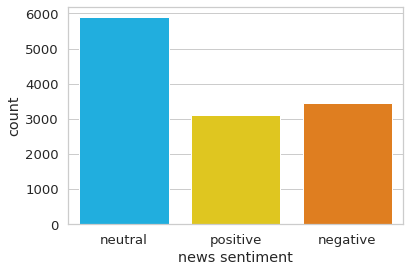

In [ ]:
class_names = ["neutral", "positive", "negative"]
ax = sns.countplot(df.label)
plt.xlabel('news sentiment')
ax.set_xticklabels(class_names)


Set up GPU for training

Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

A GPU can be added by going to the menu and selecting:

Runtime -> Change runtime type -> Hardware accelerator: GPU

Then we need to run the following cell to specify the GPU as the device.

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


D - Fine-tuning BERT

Install the Hugging Face Library
The transformer library of Hugging Face contains PyTorch implementation of state-of-the-art NLP models including BERT (from Google), GPT (from OpenAI) ... and pre-trained model weights.

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 17.8 MB/s 
     |████████████████████████████████| 6.6 MB 43.9 MB/s 
     |████████████████████████████████| 596 kB 63.0 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


BERT Tokenizer

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

Choosing Sequence Length

BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

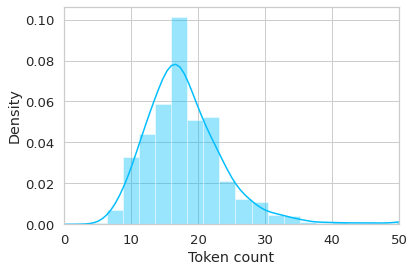

In [ ]:
token_lens = []
for txt in df.title:
  try:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))
  except:
    continue

sns.distplot(token_lens)
plt.xlim([0, 50]);
plt.xlabel('Token count')

Most of the news seem to contain less than 20 tokens, but we’ll be on the safe side and choose a maximum length of 124.

In [ ]:
print('Max length: ', max(token_lens))

Max length:  124


In [ ]:
MAX_LEN = 124

In [ ]:
class NewsDataset(Dataset):
  def __init__(self, news, targets, tokenizer, max_len):
    self.news = news
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.news)

  def __getitem__(self, item):
    new = str(self.news[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      new,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'news_text': new,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

 Let’s split the data

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.5, random_state=42)

df_val, df_test = train_test_split(df_test, test_size=0.5,random_state=42)

df_train.shape, df_val.shape

((6223, 3), (3111, 3))

Analyze by TITLE

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = NewsDataset(
    news=df.title.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Sentiment Classification with BERT and Hugging Face

In [ ]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training

In [ ]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Train loss 1.096024072415418 accuracy 0.4341957255343082


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.0582527716954548 accuracy 0.47605271616843453

Epoch 2/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 1.0730162885011314 accuracy 0.46199582195082756


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.0550080256584362 accuracy 0.47605271616843453

Epoch 3/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 1.0459258455237264 accuracy 0.4762976056564358


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.0479320941827237 accuracy 0.47573127611700416

Epoch 4/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.917470553846776 accuracy 0.5704644062349349


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.1092974950105716 accuracy 0.46126647380263575

Epoch 5/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

KeyboardInterrupt: ignored

TypeError: ignored

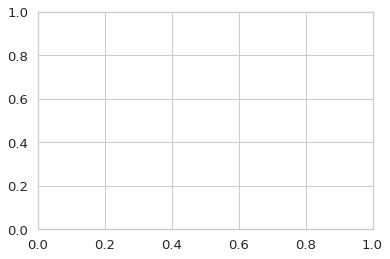

In [ ]:
# plt.plot(history['train_acc'], label='train accuracy')
# plt.plot(history['val_acc'], label='validation accuracy')
# plt.title('Training history')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.ylim([0, 1]);

calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

0.43830334190231357